---

**APRP: 2. Introduction to Probabilistic Graphical Models**

---


**Contents**
--------
1. What is A Probabilistic Graphical Model
2. Modelling Conditional Probabilities as Graphs
3. Bayesian Networks
4. Using pgmpy package


### 1. Setting up the enviroment
Loading common Libraries. 

We are also import the pgmpy package (https://pgmpy.org/) for Bayesian Networks. It implemnts alogrithms for Structure Learning, Parameter Estimation, Approximate and Exact inference, and Causal Inference.


In [8]:
import numpy as np
import pandas as pd
from IPython.display import Image

#!pip install pgmpy #<-- IF not installed already
import pgmpy
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.utils import get_example_model


### 2. Testing a Bayesian Network

Proababilistic Graphical Models (PGM): PGM is a technique of compactly representing Joint Probability Distribution over random variables by exploiting the (conditional) independencies between the variables. PGM also provides us methods for efficiently doing inference over these joint distributions.

Each graphical model is characterized by a graph structure (can be directed, undirected or both) and a set of parameters associated with each graph.


Create the Alarm Bayesian Network using pgmpy and do some simple queries on the network. This network is mentioned in Bayesian Artificial Intelligence - Section 2.5.1 (https://bayesian-intelligence.com/publications/bai/book/BAI_Chapter2.pdf)






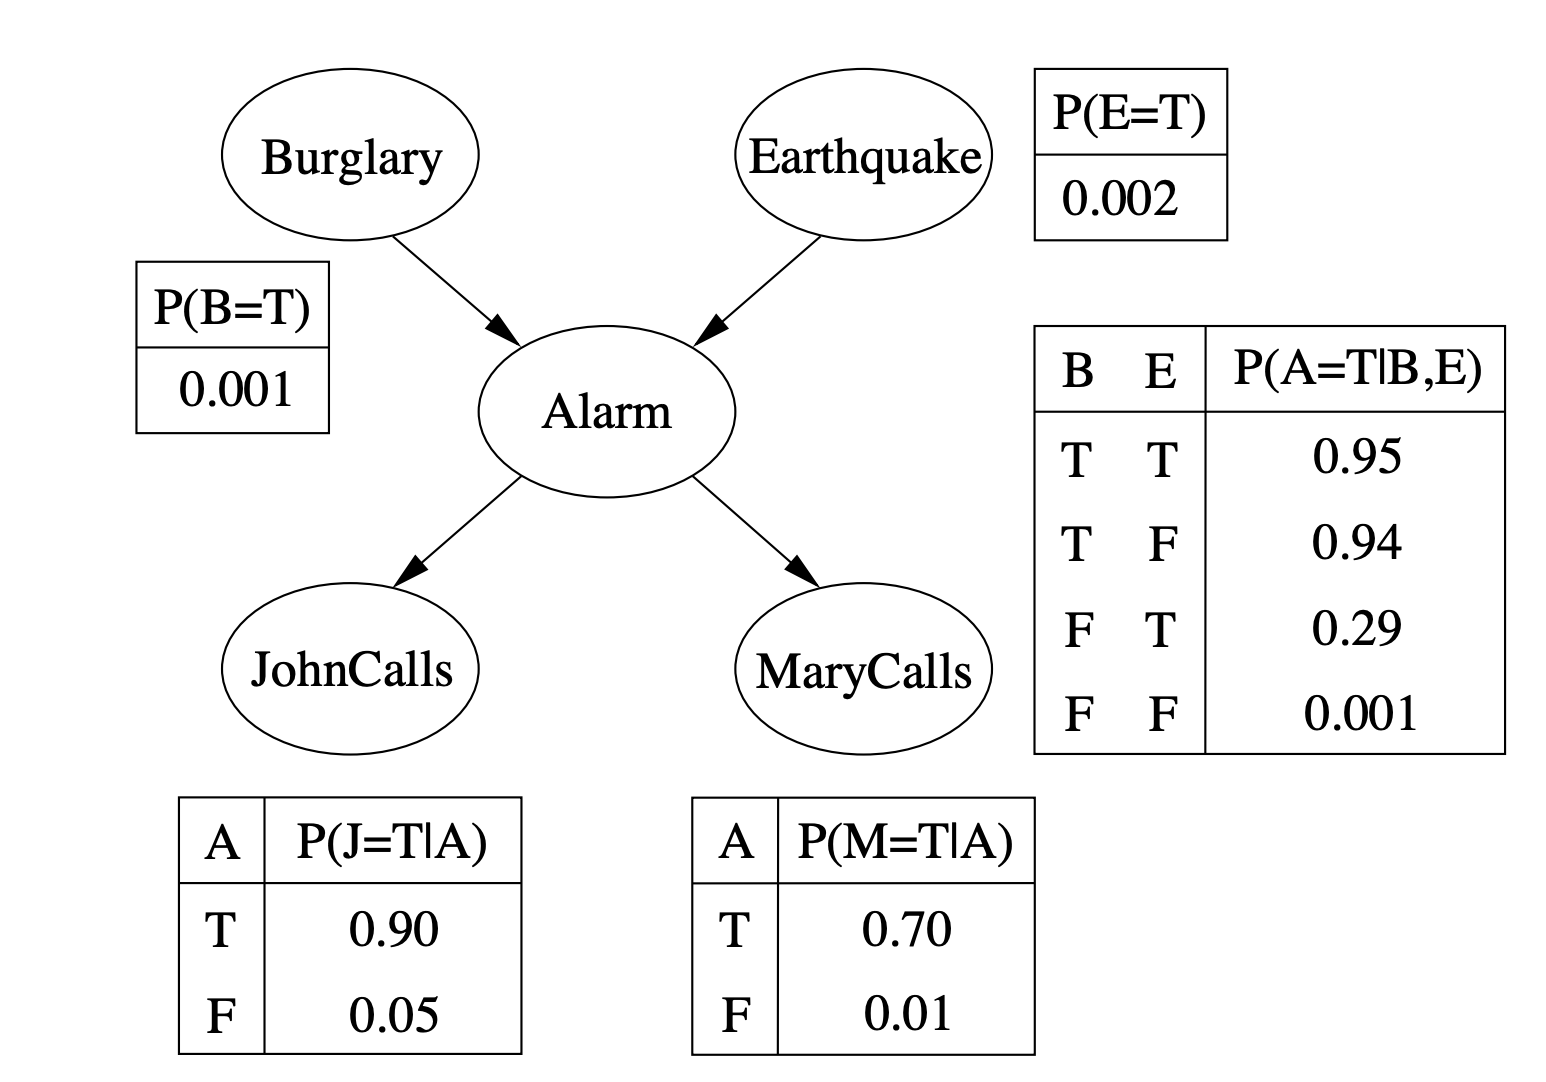

In [9]:
Image(filename='alarm.png')

In [10]:
# Defining network structure

alarm_model = BayesianNetwork(
    [
        ("Burglary", "Alarm"),
        ("Earthquake", "Alarm"),
        ("Alarm", "JohnCalls"),
        ("Alarm", "MaryCalls"),
    ]
)

# Defining the parameters using CPT
from pgmpy.factors.discrete import TabularCPD

cpd_burglary = TabularCPD(
    variable="Burglary", 
    variable_card=2, 
    values=[[0.999], [0.001]]
)
cpd_earthquake = TabularCPD(
    variable="Earthquake", 
    variable_card=2, 
    values=[[0.998], [0.002]]
)
cpd_alarm = TabularCPD(
    variable="Alarm",
    variable_card=2,
    values=[[0.999, 0.71, 0.06, 0.05], [0.001, 0.29, 0.94, 0.95]],
    evidence=["Burglary", "Earthquake"],
    evidence_card=[2, 2],
)
cpd_johncalls = TabularCPD(
    variable="JohnCalls",
    variable_card=2,
    values=[[0.95, 0.1], [0.05, 0.9]],
    evidence=["Alarm"],
    evidence_card=[2],
)
cpd_marycalls = TabularCPD(
    variable="MaryCalls",
    variable_card=2,
    # values=[[0.3, 0.99], [0.7, 0.01]],
    values=[[0.99, 0.3], [0.01, 0.7]],
    evidence=["Alarm"],
    evidence_card=[2],
)

# Associating the parameters with the model structure
alarm_model.add_cpds(
    cpd_burglary, cpd_earthquake, cpd_alarm, cpd_johncalls, cpd_marycalls
)

In [11]:


# Checking if the cpds are valid for the model
alarm_model.check_model()
# Viewing nodes of the model
alarm_model.nodes()
# Viewing edges of the model
alarm_model.edges()
# Checking independcies of a node
alarm_model.local_independencies("Earthquake")

(Earthquake ⟂ Burglary)

### 3. Writting the Bayes Net to a BIF file
Loading common Libraries. 

In [12]:
from pgmpy.readwrite import BIFWriter
from pgmpy.readwrite import BIFReader
writer = BIFWriter(alarm_model)
writer.write_bif(filename='alarm_model2.bif')

alarm_model2 = BIFReader("alarm_model2.bif").get_model()

### 4. Drawing conclusion from the data


In [13]:
#Return the probability of the given set of states. 
#The probability that the alarm has sounded but neither a burglary nor an earthquake has occurred, and both John and Mary calls
q = alarm_model.get_state_probability({"Burglary": 0,"Earthquake":0,"JohnCalls":1,"MaryCalls":1,"Alarm":1})
print(q)

0.0006281112599999999


In [14]:
# Computing the probability that John calls?
infer = VariableElimination(alarm_model)
q = infer.query(variables=["JohnCalls"])
print(q)

# Computing the probability that there is a burglary given that John and Mary calls?
q = infer.query(variables=["Burglary"], evidence={"JohnCalls": 1,"MaryCalls":1})
#print(q)


# Computing the joint probability given Alarm=1
q = infer.query(variables=["JohnCalls", "MaryCalls","Burglary","Earthquake"], evidence={"Alarm": 1})
#print(q)

# Computing the probabilities (not joint)  given Alarm=1
q = infer.query(variables=["JohnCalls", "MaryCalls"], evidence={"Alarm": 1}, joint=False)
#for factor in q.values():
 #   print(factor)




+--------------+------------------+
| JohnCalls    |   phi(JohnCalls) |
+==============+==================+
| JohnCalls(0) |           0.9479 |
+--------------+------------------+
| JohnCalls(1) |           0.0521 |
+--------------+------------------+


Try to answer this questions: %TODO%
- What is the probability of Mary calling given that John called?
- What is the probability of a Burglary given that John and Mary called?
- Propose 2 more relevant questions.
- What is the probability of an Earthquake given that John and Mary called?
- What is the probability of an Earthquake given that the alarm did not sound and John and Mary called?


In [15]:
# What is the probability of Mary calling given that John called?

# Computing the probability that Mary calls?
infer = VariableElimination(alarm_model)
q = infer.query(variables=["MaryCalls"])
#print(q)

# Computing the probability that Mary calling given that John called?
q = infer.query(variables=["MaryCalls"], evidence={"JohnCalls": 1})
print(q)


# Computing the joint probability given Alarm=1
q = infer.query(variables=["JohnCalls", "MaryCalls","Burglary","Earthquake"], evidence={"Alarm": 1})
#print(q)

# Computing the probabilities (not joint)  given Alarm=1
q = infer.query(variables=["JohnCalls", "MaryCalls"], evidence={"Alarm": 1}, joint=False)
#for factor in q.values():
#    print(factor)

+--------------+------------------+
| MaryCalls    |   phi(MaryCalls) |
+==============+==================+
| MaryCalls(0) |           0.9600 |
+--------------+------------------+
| MaryCalls(1) |           0.0400 |
+--------------+------------------+


In [16]:
# What is the probability of a Burglary given that John and Mary called?

# Computing the probability that John calls?
infer = VariableElimination(alarm_model)
q = infer.query(variables=["Burglary"])
#print(q)

# Computing the probability that there is a burglary given that John and Mary calls?
q = infer.query(variables=["Burglary"], evidence={"JohnCalls": 1,"MaryCalls":1})
print(q)


# Computing the joint probability given Alarm=1
q = infer.query(variables=["JohnCalls", "MaryCalls","Burglary","Earthquake"], evidence={"Alarm": 1})
#print(q)

# Computing the probabilities (not joint)  given Alarm=1
q = infer.query(variables=["JohnCalls", "MaryCalls"], evidence={"Alarm": 1}, joint=False)
#for factor in q.values():
#    print(factor)

+-------------+-----------------+
| Burglary    |   phi(Burglary) |
+=============+=================+
| Burglary(0) |          0.7158 |
+-------------+-----------------+
| Burglary(1) |          0.2842 |
+-------------+-----------------+


In [17]:
# What is the probability of an Earthquake given that John and Mary called?

# Computing the probability that John calls?
infer = VariableElimination(alarm_model)
q = infer.query(variables=["Earthquake"])
#print(q)

# Computing the probability that there is a burglary given that John and Mary calls?
q = infer.query(variables=["Earthquake"], evidence={"JohnCalls": 1,"MaryCalls":1})
print(q)


# Computing the joint probability given Alarm=1
q = infer.query(variables=["JohnCalls", "MaryCalls","Burglary","Earthquake"], evidence={"Alarm": 1})
#print(q)

# Computing the probabilities (not joint)  given Alarm=1
q = infer.query(variables=["JohnCalls", "MaryCalls"], evidence={"Alarm": 1}, joint=False)
#for factor in q.values():
 #   print(factor)

+---------------+-------------------+
| Earthquake    |   phi(Earthquake) |
+===============+===================+
| Earthquake(0) |            0.8239 |
+---------------+-------------------+
| Earthquake(1) |            0.1761 |
+---------------+-------------------+


In [18]:
# What is the probability of a Earthquake given that the alarm did not sound and John and Mary called?

# Computing the probability that Earthquake calls?
infer = VariableElimination(alarm_model)
q = infer.query(variables=["Burglary"])
#print(q)

# Computing the probability that there is a burglary given that John and Mary calls?
q = infer.query(variables=["Earthquake"], evidence={"JohnCalls": 1,"MaryCalls":1, "Alarm":0})
print(q)


# Computing the joint probability given Alarm=1
q = infer.query(variables=["JohnCalls", "MaryCalls","Burglary","Earthquake"], evidence={"Alarm": 1})
#print(q)

# Computing the probabilities (not joint)  given Alarm=1
q = infer.query(variables=["JohnCalls", "MaryCalls"], evidence={"Alarm": 1}, joint=False)
#for factor in q.values():
 #   print(factor)

+---------------+-------------------+
| Earthquake    |   phi(Earthquake) |
+===============+===================+
| Earthquake(0) |            0.9986 |
+---------------+-------------------+
| Earthquake(1) |            0.0014 |
+---------------+-------------------+


### 5. Test the asia.bif dataset %TODO%
Prepare a Jupyter NoteBook report for the analysis of the asia.bif dataset. Include:
- Analysis and intepretation of the dataset.
- Prepapre a graphical representation of the dependencies
- Analyse the indedependencies
- Draw conclusion from the data. Ilustrate exemples of the 

### 5.1 Asia.bif  Dataset analysis and interpertation
The asia.bif dataset is used to compute the probability of a patient having lung cancer or tuberculosis. Bayesian network consisting of 8 nodes:
- asia - visit to asia or not, being a risk factor for tuberculosis
- smoke - If the patient is smoker or non-smoker, being a risk factor for lung cancer.
- tuberculosis - If the patient has tuberculosis or not  
- lung - If the patient has lung cancer or not 

- bronc - If the patient has bronchitis or not 
- either - Wether the patient has either tuberculosis or lung cancer, but not booth
- xray - If the X-ray is normal or not, an abnormal X-ray indicates the presence of one of the diseases 
- dysp - If the patient suffers of dyspnea or not, symptom of both tuberculosis or lung cancer  

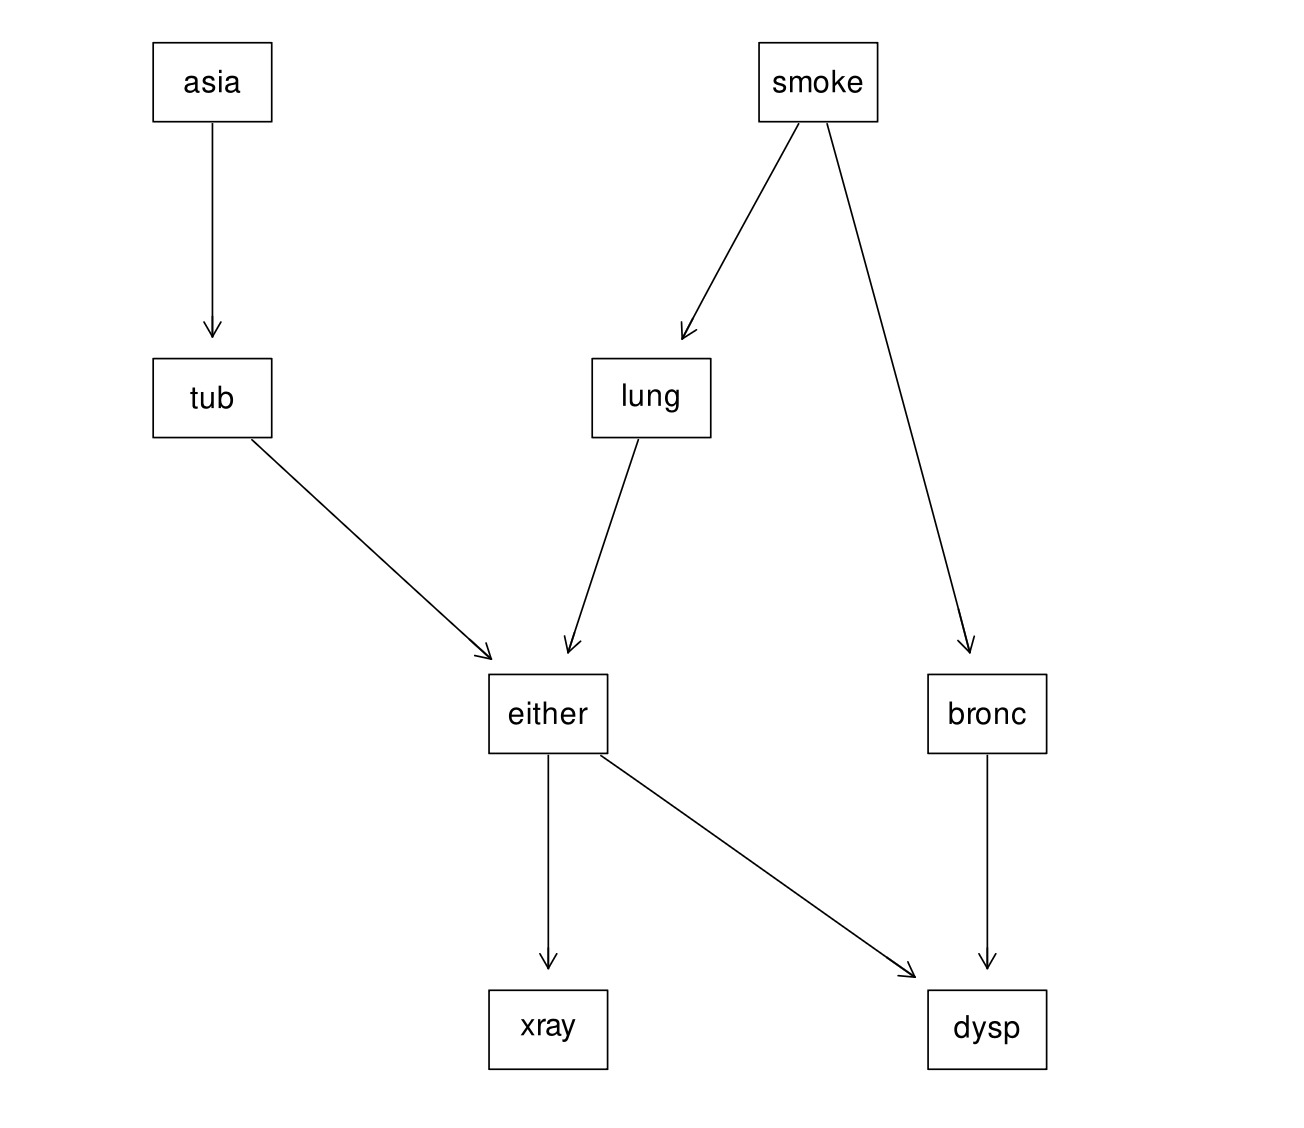

In [21]:
Image(filename='asia_network.png')

In [22]:
# Defining network structure

asian_model = BayesianNetwork(
    [
        ("asia", "tub"),
        ("smoke", "lung"),
        ("tub", "either"),
        ("lung", "either"),
        ("smoke", "bronc"),
        ("either", "dysp"),
        ("either", "xray"),
        ("bronc", "dysp"),
    ]
)


# Defining the parameters using CPT
from pgmpy.factors.discrete import TabularCPD

cpd_asia = TabularCPD(
    variable="asia", 
    variable_card=2, 
    values=[[0.99], [0.01]]
)
cpd_tub = TabularCPD(
    variable="tub", 
    variable_card=2, 
    values=[[0.99, 0.95], [0.01, 0.05]],
    evidence=["asia"],
    evidence_card=[2],
)
cpd_smoke = TabularCPD(
    variable="smoke", 
    variable_card=2, 
    values=[[0.5], [0.5]]
)
cpd_lung = TabularCPD(
    variable="lung", 
    variable_card=2, 
    values=[[0.99, 0.9], [0.01, 0.1]],
    evidence=["smoke"],
    evidence_card=[2],
)
cpd_bronc = TabularCPD(
    variable="bronc", 
    variable_card=2, 
    values=[[0.7, 0.4], [0.3, 0.6]],
    evidence=["smoke"],
    evidence_card=[2],
)
cpd_either = TabularCPD(
    variable="either",
    variable_card=2,
    values=[[1.0, 0.0, 0.0, 0.0],[0.0, 1.0, 1.0, 1.0]],
    evidence=["tub", "lung"],
    evidence_card=[2, 2],
)
cpd_xray = TabularCPD(
    variable="xray",
    variable_card=2,
    values=[[0.95, 0.02],[0.05, 0.98]],
    evidence=["either"],
    evidence_card=[2],
)
cpd_dysp = TabularCPD(
    variable="dysp",
    variable_card=2,
    values=[[0.9, 0.3, 0.2, 0.1],[0.1, 0.7, 0.8, 0.9]],
    evidence=["either", "bronc"],
    evidence_card=[2, 2],
)

# Associating the parameters with the model structure
asian_model.add_cpds(
    cpd_asia, cpd_tub, cpd_smoke, cpd_lung, cpd_either, cpd_bronc, cpd_xray, cpd_dysp
)
    

In [23]:
# Checking if the cpds are valid for the model
asian_model.check_model()
# Viewing nodes of the model
asian_model.nodes()
# Viewing edges of the model
asian_model.edges()
# Checking independcies of a node
print(asian_model.local_independencies("asia"))
print(asian_model.local_independencies("smoke"))
print(asian_model.local_independencies("tub"))
print(asian_model.local_independencies("lung"))
print(asian_model.local_independencies("either"))
print(asian_model.local_independencies("bronc"))
print(asian_model.local_independencies("xray"))
print(asian_model.local_independencies("dysp"))

(asia ⟂ bronc, lung, smoke)
(smoke ⟂ tub, asia)
(tub ⟂ bronc, lung, smoke | asia)
(lung ⟂ bronc, tub, asia | smoke)
(either ⟂ bronc, asia, smoke | tub, lung)
(bronc ⟂ tub, asia, either, xray, lung | smoke)
(xray ⟂ bronc, tub, dysp, asia, smoke, lung | either)
(dysp ⟂ tub, asia, smoke, xray, lung | bronc, either)


### 5.2 Analysis of the dependencies
Below there is a graphical representation of the Bayesian Network for the Asia dataset with the following nodes: 
- Asia - directly connected to Tuberculosis node, is independent to Lung, Smoke and Bronchitis
- Smoke - directly connected to Lung and Bronchitis nodes, is independent to Asia and Tuberculosis
- Tuberculosis - directly connected to Asia and Either nodes, is independent to Lung, Smoke and Bronchitis
- Lung - directly connected to Smoke and Either nodes, is independent to Asia, Tuberculosis and Bronchitis 
- Bronchitis - directly connected to Smoke and Dyspnea nodes, it is independent to Asia, Lung, Tuberculosis and Either
- Either - directly connected to Tuberculosis, Lung, X-ray and Dyspnea, it is independent to Asia, Smoke and Bronchitis
- X-ray - directly connected to Either, it is independent to Asia, Lung, Smoke, Tuberculosis, Dyspnea and Bronchitis

- Dyspnea - directly connected to Either and Bronchitis, is independent to Asia, Lung, Smoke, Tuberculosis, X-ray

### 5.3 Writting the Bayes Net to a BIF file

In [24]:
from pgmpy.readwrite import BIFWriter
from pgmpy.readwrite import BIFReader
writer = BIFWriter(asian_model)
writer.write_bif(filename='asian_model4.bif')



In [25]:
asian_model4 = BIFReader("asian_model4.bif").get_model()



In [26]:
# Checking if the cpds are valid for the model
asian_model4.check_model()
# Viewing nodes of the model
asian_model4.nodes()
# Viewing edges of the model
asian_model4.edges()
# Checking independcies of a node
print(asian_model4.local_independencies("asia"))
print(asian_model4.local_independencies("smoke"))
print(asian_model4.local_independencies("tub"))
print(asian_model4.local_independencies("lung"))
print(asian_model4.local_independencies("either"))
print(asian_model4.local_independencies("bronc"))
print(asian_model4.local_independencies("xray"))
print(asian_model4.local_independencies("dysp"))

(asia ⟂ bronc, lung, smoke)
(smoke ⟂ tub, asia)
(tub ⟂ bronc, lung, smoke | asia)
(lung ⟂ bronc, tub, asia | smoke)
(either ⟂ bronc, asia, smoke | tub, lung)
(bronc ⟂ tub, asia, either, xray, lung | smoke)
(xray ⟂ bronc, tub, dysp, asia, smoke, lung | either)
(dysp ⟂ tub, asia, smoke, xray, lung | bronc, either)


### 5.4 Drawing conclusion from the data


In [27]:
# Computing the probability that the patient has tuberculosis?
infer = VariableElimination(asian_model)
q = infer.query(variables=["tub"])
#print(q)

# Computing the probability of having tuberculosis given that visited asia, suffers of dyspnea and X-ray is abnormal?
q = infer.query(variables=["tub"], evidence={"xray":1,"asia":1,"dysp":1})
print(q)


# Computing the joint probability given Tub=1
q = infer.query(variables=["asia","xray","dysp"], evidence={"tub": 1})
#print(q)

# Computing the probabilities (not joint)  given tub=1
q = infer.query(variables=["xray", "dysp"], evidence={"tub": 1}, joint=False)
#for factor in q.values():
#    print(factor)

+--------+------------+
| tub    |   phi(tub) |
+========+============+
| tub(0) |     0.5929 |
+--------+------------+
| tub(1) |     0.4071 |
+--------+------------+


##### Exemplos %TO DO% talvez
- What is the probability of having lung cancer given that the patient is a smoker and has an abnormal X-ray result?
- What is the probability of having either tuberculosis or lung cancer given that the patient has dyspnea and an abnormal X-ray result ?

- What is the probability of being a smoker given that the patient has dyspnea and an abnormal X-ray result?
- What is the probability of having tuberculosis given that the patient has dyspnea and bronchitis?
- What is the probability of having an abnormal X-ray given that the patient has tuberculosis and visited Asia?



In [28]:
#What is the probability of being a smoker given that the patient has dyspnea and an abnormal X-ray result?
q = infer.query(variables=["smoke"], evidence={"xray":1,"dysp":1})
print(q)

+----------+--------------+
| smoke    |   phi(smoke) |
+==========+==============+
| smoke(0) |       0.2115 |
+----------+--------------+
| smoke(1) |       0.7885 |
+----------+--------------+
